# Bayesian Networks for Predicting Cardiovascular Diseases #

## Group 10 ##
**Francisco Papoula - FC58238** 

**António Almeida   - FC58235**

In [3]:
from pgmpy.models import BayesianNetwork
import pandas as pd
from IPython.display import Image, display
import matplotlib.pyplot as plt
from pgmpy.estimators import MaximumLikelihoodEstimator
import numpy as np
from pgmpy.inference import VariableElimination
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import HillClimbSearch, BicScore, K2Score, BDeuScore, AICScore
import networkx as nx
from pgmpy.base import DAG
from imblearn.over_sampling import SMOTE


import matplotlib.pyplot as plt

Load the datasets

In [4]:


# Load the datasets
train_data = pd.read_csv('cardiovascular_train.csv')
test_data = pd.read_csv('cardiovascular_test.csv')



## Step 1: Exploratory Data Analysis (EDA) ##
The dataset used for this study provides key insights into cardiovascular risk factors, grouped into non-modifiable factors, modifiable factors, and medical conditions. Understanding these distributions is essential for modeling and prediction.



**Identification off the variables and their unique values:**

In [5]:
for column in train_data.columns:
    unique_values = train_data[column].unique()
    print(f"{column}: {unique_values}")

Age: ['54-64' '24-34' '34-44' '44-54' '64-74' '18-24']
Anxiety: ['No' 'Yes']
BodyMassIndex: ['Overweight' 'Obese' 'Normal' 'Underweight']
Depression: ['No' 'Yes']
Diabetes: ['No' 'Yes']
EducationLevel: [2 3 1]
Hypercholesterolemia: ['No' 'Yes']
Hypertension: ['No' 'Yes']
PhysicalActivity: ['Regularly Active' 'Insufficiently Active']
Sex: ['Male' 'Female']
SleepDuration: ['6-9hours' '<6hours' '>9hours']
SmokerProfile: ['Smoker' 'Non_Smoker' 'Ex_Smoker']
SocioeconomicStatus: [3 1 2]


We decided to convert the data into numerical values, giving us the option to analyse the mean and other statistical values, leading to more informed conclusions in the analysis of the data.

description
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3845 entries, 0 to 3844
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Age                   3845 non-null   object
 1   Anxiety               3845 non-null   object
 2   BodyMassIndex         3845 non-null   object
 3   Depression            3845 non-null   object
 4   Diabetes              3845 non-null   object
 5   EducationLevel        3845 non-null   int64 
 6   Hypercholesterolemia  3845 non-null   object
 7   Hypertension          3845 non-null   object
 8   PhysicalActivity      3845 non-null   object
 9   Sex                   3845 non-null   object
 10  SleepDuration         3845 non-null   object
 11  SmokerProfile         3845 non-null   object
 12  SocioeconomicStatus   3845 non-null   int64 
dtypes: int64(2), object(11)
memory usage: 390.6+ KB
Statistics
       EducationLevel  SocioeconomicStatus
count     3845.000000   

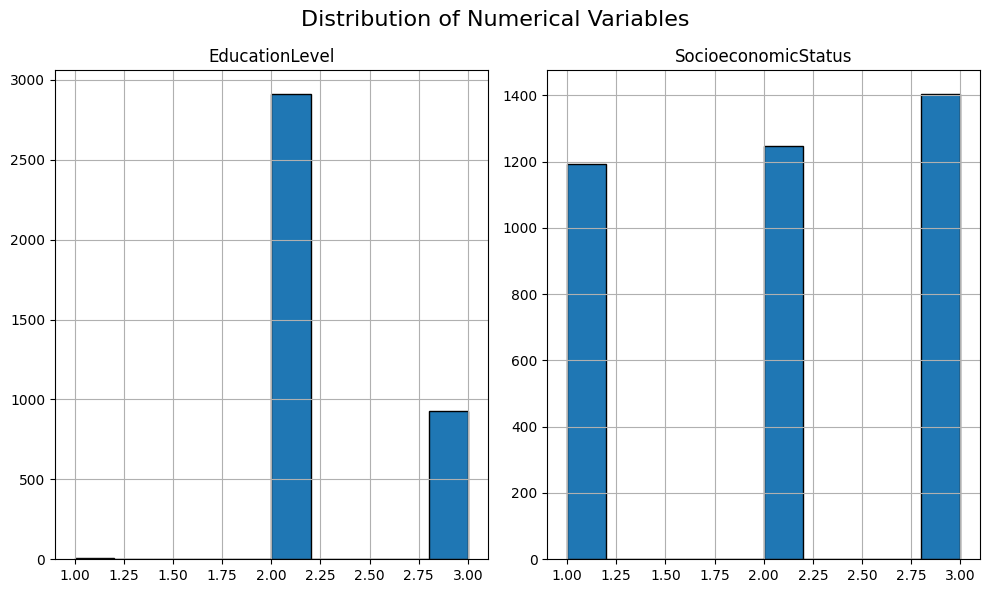

In [6]:
print("description")
train_data.info()

# Get a summary of statistics for numerical columns
print("Statistics")
print(train_data.describe())

# List of categorical columns
categorical_vars = train_data.select_dtypes(include=['object']).columns

for column in train_data.columns:
    print(f"Occurrences of unique values in '{column}':")
    print(train_data[column].value_counts())
    print()

# List of numerical columns
numerical_vars = train_data.select_dtypes(include=['int64']).columns

train_data[numerical_vars].hist(bins=10, figsize=(10, 6), edgecolor='black')
plt.suptitle('Distribution of Numerical Variables', fontsize=16)
plt.tight_layout()
plt.show()



**Non-Modifiable Risk Factors:**

The dataset includes participants from various ages, but most are in the 34-44 and 44-54 age groups, representing 36.7% and 29.9% of the total, respectively. Representation in the extremes is minimal, with only 28 participants aged 18-24 and 9 aged 64-74. Regarding sex, the dataset is mostly male (2,618, 68.1%) compared to female (1,227, 31.9%). Education level is mostly mid-level education (2,914 participants, 75.8%), while low education (level 1) is very rare (5 participants). Socioeconomic status is relatively balanced, with the highest category (level 3) accounting for 36.5%, medium (level 2) at 32.4%, and low (level 1) at 31.1%.

**Modifiable Risk Factors:**

Lifestyle behaviors show distinct patterns: insufficient physical activity is very predominant (2,770 participants, 72.0%), with only 1,075 participants (28.0%) reporting regular activity. Sleep duration is predominantly within the recommended 6-9 hours range (3,440 participants, 89.5%). Short sleep durations (<6 hours) affect 10.4% of participants, while extended sleep durations (>9 hours) are extremely rare (4 participants, 0.1%).

Regarding BMI, the distribution shows a significant number of overweight individuals (1,440 participants, 37.4%) and a slightly lower but still significant number classified as obese (968 participants, 25.2%). Normal weight accounts for 34.9%, while underweight is rare (2.4%). Smoking profiles indicate that non-smokers form the largest group (56.6%), followed by smokers (27.0%) and ex-smokers (16.4%). Mental health conditions include anxiety, reported by 10.2% of participants, and depression, which is rare, affecting only 0.5% of the sample.

**Medical Conditions:**

The percentage of chronic medical conditions varies widely. Hypercholesterolemia is the most common, affecting 38.8% of participants, followed by hypertension (19.2%) and diabetes (4.6%). These conditions are the main targets for our prediction model.

**Key Observations Summary:**
- Imbalances in Variables: Depression, diabetes, and long sleep durations are highly imbalanced and could require oversampling techniques for effective classification, however, this will only be done for the diabetes, in the 5th step of the report.
- Common Risk Factors: Insufficient physical activity, overweight/obesity, and hypercholesterolemia are very common.
- Demographics: The dataset is inclined toward middle-aged males with mid-level education and balanced socioeconomic status.

## Step 2: Structure learning ##

  0%|          | 40/1000000 [00:01<10:10:29, 27.30it/s]


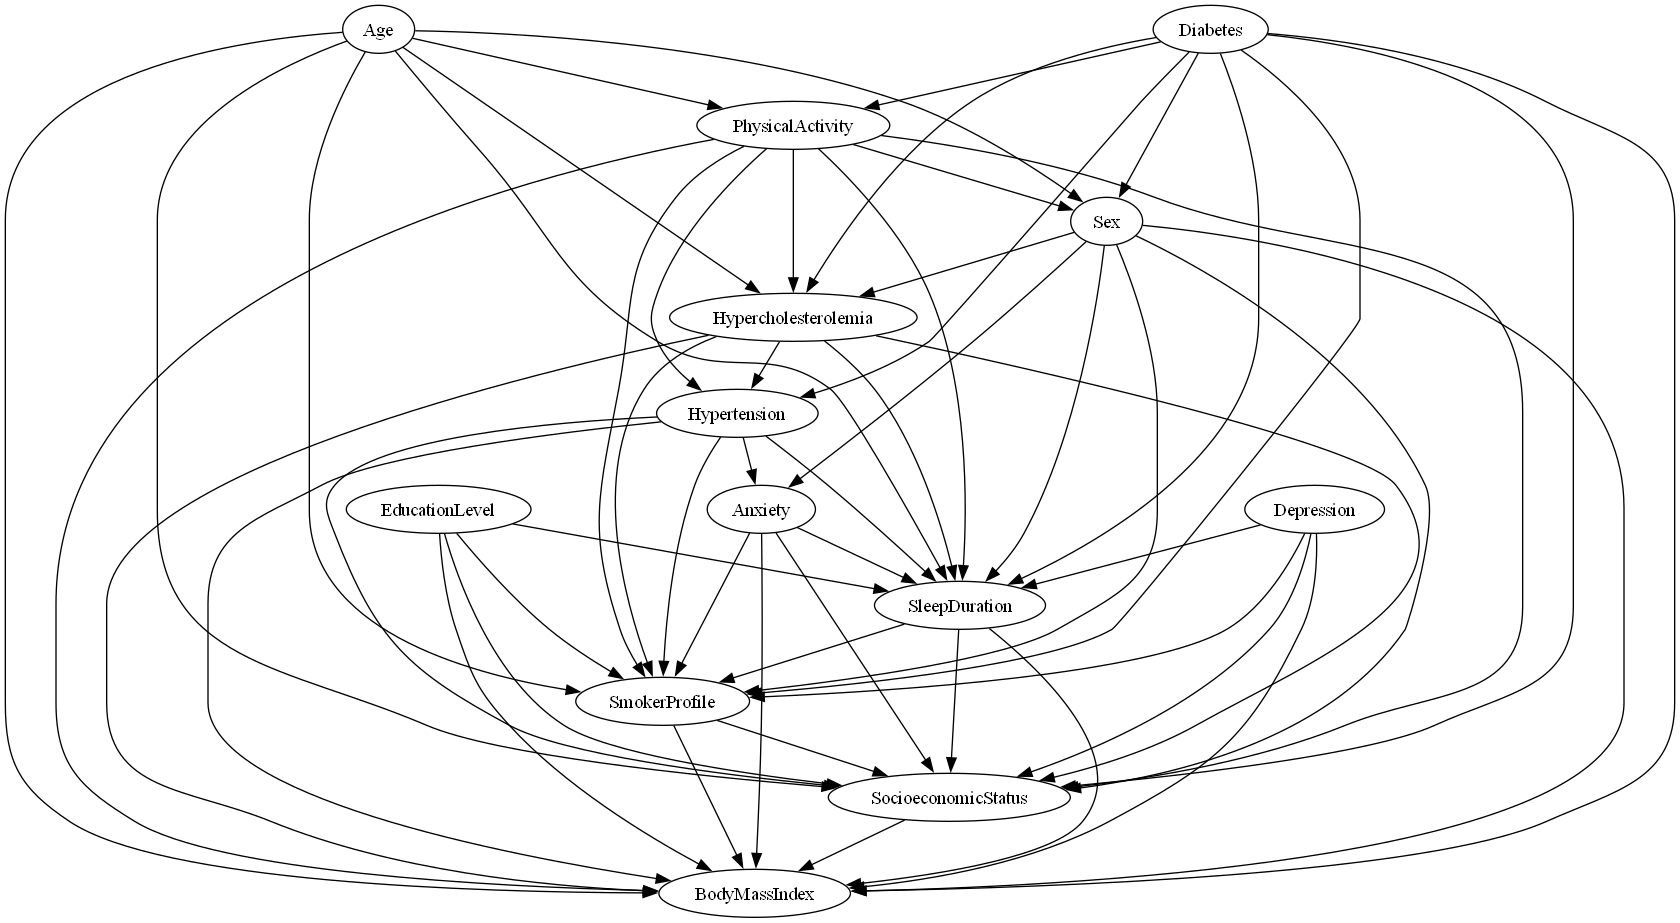

  0%|          | 72/1000000 [00:01<7:13:01, 38.49it/s] 


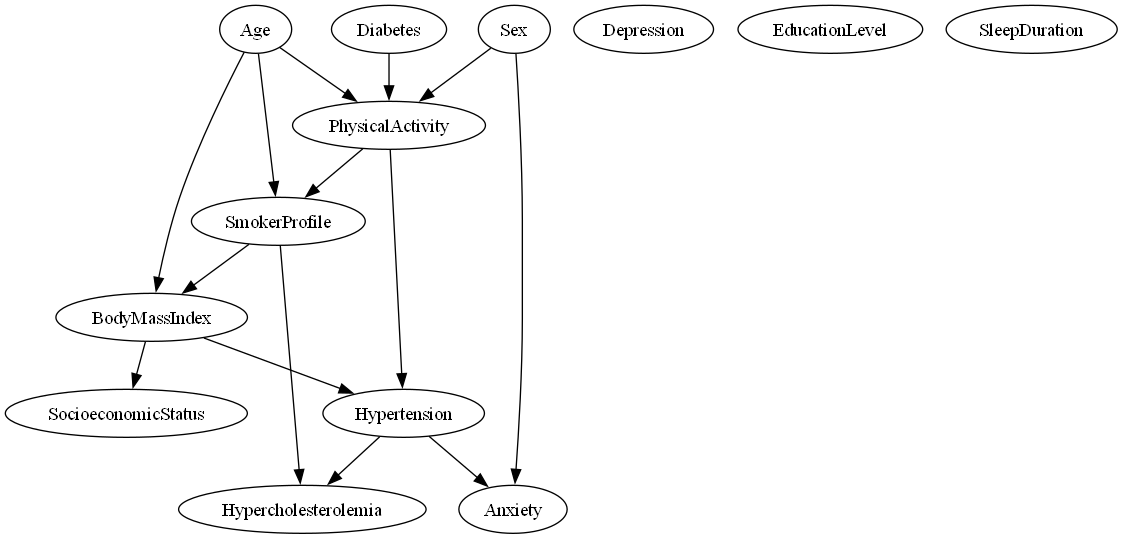

  0%|          | 69/1000000 [00:01<7:26:44, 37.31it/s] 


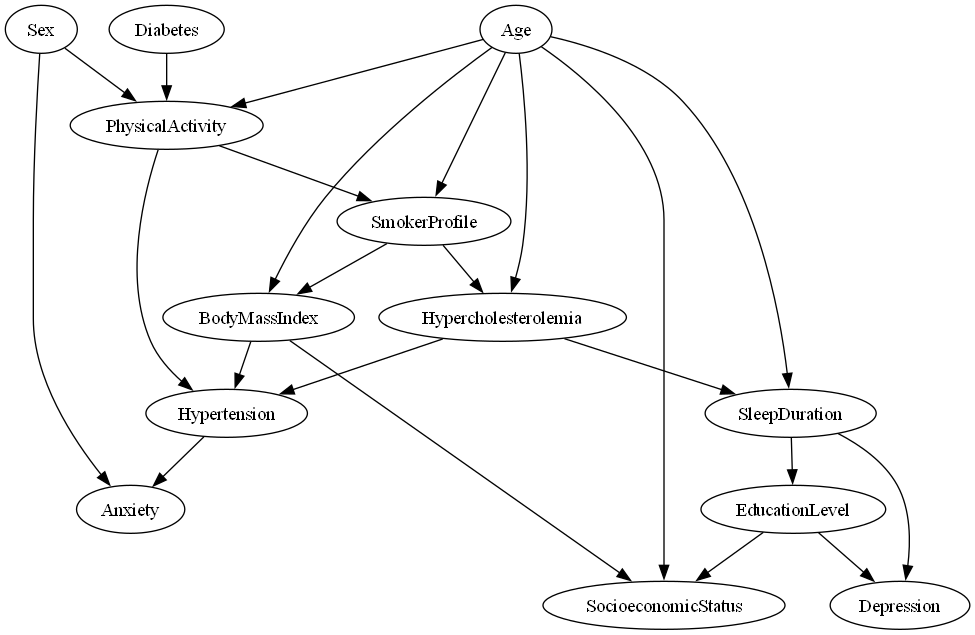

  0%|          | 59/1000000 [00:01<8:17:01, 33.53it/s] 


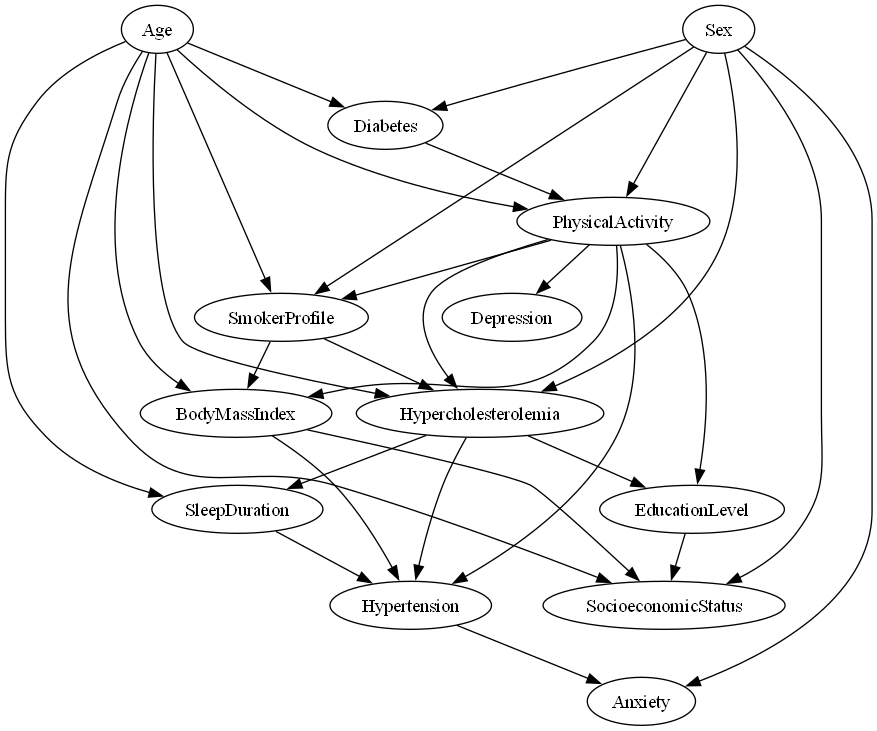

In [35]:
forbidden_edges = [(source, target) for target in ['Age', 'Sex'] for source in train_data.columns if source != target]
def initialize_graph(nodes,p=1):
    G = DAG()
    G.add_nodes_from(nodes=nodes)
    init = G.get_random(n_nodes=len(nodes), edge_prob=p)
    ls = []
    mapping = {}
    for k in range(len(nodes)):
        mapping[k] = nodes[k]
    for i,j in init.edges:
        ls.append((mapping[i],mapping[j]))
    ls
    G.add_edges_from(ebunch=ls) # G is the required initialization for the Hill Climbing method
    return G


def best_by_scorer(scorer):
    maximum = float('-inf')
    best_model = None
    es = HillClimbSearch(data=train_data)
    for item in [x * 0.1 for x in range(0,11)]:
        model = es.estimate(scoring_method=scorer, start_dag=initialize_graph(nodes = train_data.columns, p=item), black_list=forbidden_edges)
        score = scorer.score(model)
        if  score > maximum:
            maximum = score
            best_model = model
    return best_model

scorers = {
    "K2": K2Score(train_data),
    "BIC": BicScore(train_data),
    "BDeu": BDeuScore(train_data),
    "AIC": AICScore(train_data)
}

best_models = {}

for name, scorer in scorers.items():
    best_model = best_by_scorer(scorer)
    best_models[name] = best_model  # Save the best model
    graph = best_model.to_graphviz()
    img = graph.draw(format='png', prog='dot')
    display(Image(img))

We selected the AIC model because we read the nodes and it was the model that made more sense while maintaining simplicity. Creating the model and fitting the data

In [36]:
best_model = best_models["AIC"]
model = BayesianNetwork(list(best_model.edges()))
model.fit(train_data,estimator=MaximumLikelihoodEstimator)
infer = VariableElimination(model)


3. Problem analysis

a. How age affects sleep duration

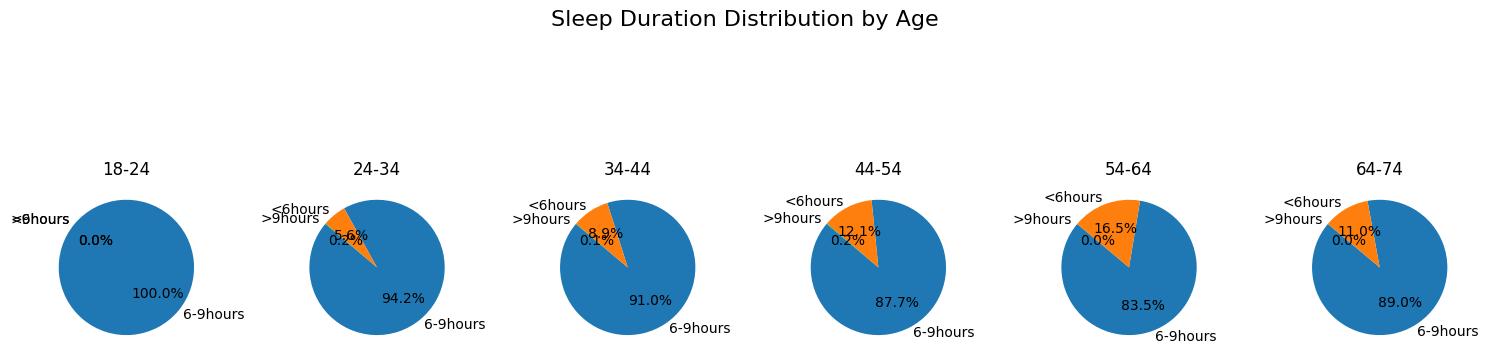

In [37]:
# Create a figure and axis array for subplots
fig, axes = plt.subplots(1, len(train_data['Age'].unique()), figsize=(15, 5))

# Loop through Age values and create a subplot for each
for i, age_value in enumerate(sorted(train_data['Age'].unique())):
    # Query the inference for SleepDuration given Age
    result = infer.query(variables=['SleepDuration'], evidence={'Age': age_value})
    
    states = result.state_names['SleepDuration']
    probabilities = result.values
    
    # Plot the pie chart on the corresponding axis
    ax = axes[i]  # Access the subplot for the current Age value
    ax.pie(probabilities, labels=states, autopct='%1.1f%%', startangle=140)
    ax.set_title(age_value)  # Remove individual titles for each subplot

# Add a single title for the entire figure
fig.suptitle('Sleep Duration Distribution by Age', fontsize=16)

# Adjust the layout and display the figure
plt.tight_layout()
plt.show()


b. How the smoker profile affects the three medical conditions

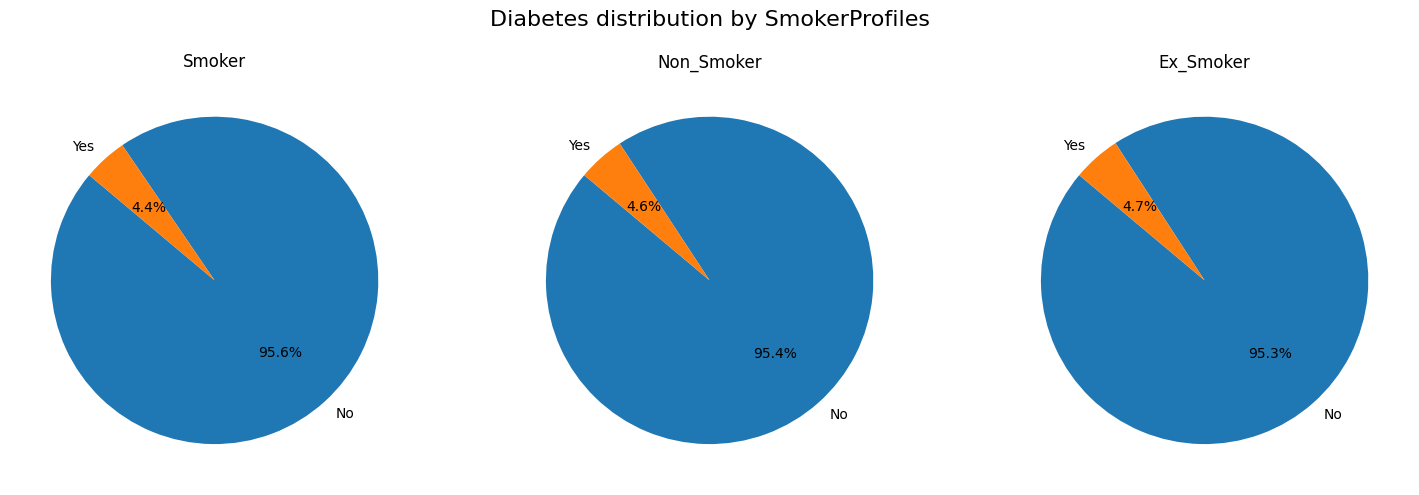

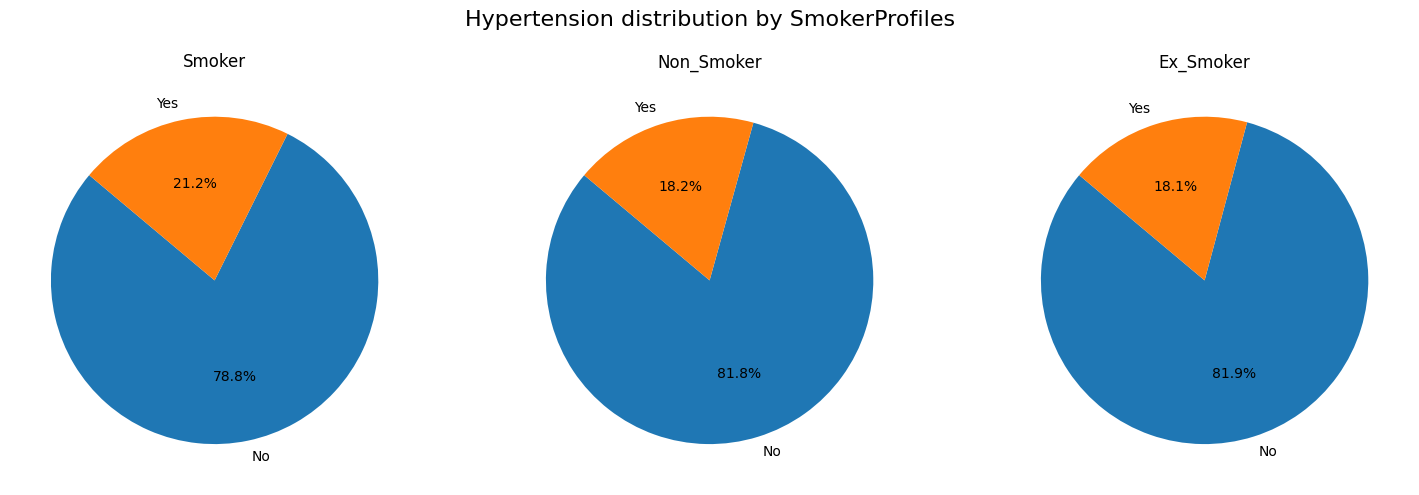

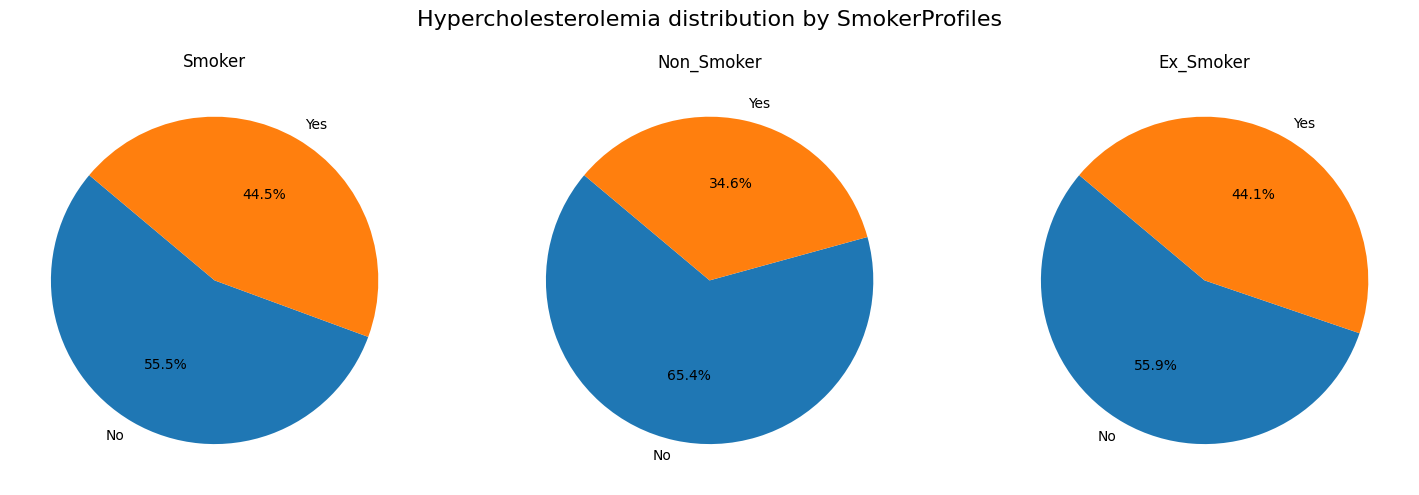

In [38]:
import matplotlib.pyplot as plt

# List of diseases to query
diseases = ['Diabetes', 'Hypertension', 'Hypercholesterolemia']

# Loop through each disease to generate a separate graph for each
for disease in diseases:
    # Create a figure for the current disease
    fig, axes = plt.subplots(1, len(train_data['SmokerProfile'].unique()), figsize=(15, 5))
    
    # Loop through smoker profiles
    for j, smoker_profile in enumerate(train_data['SmokerProfile'].unique()):
        # Query the inference for the disease given SmokerProfile
        result = infer.query(variables=[disease], evidence={'SmokerProfile': smoker_profile})
        
        # Extract states and their probabilities
        states = result.state_names[disease]
        probabilities = result.values

        # Plot the pie chart for the current smoker profile
        ax = axes[j]  # Access the subplot for the current smoker profile
        ax.pie(probabilities, labels=states, autopct='%1.1f%%', startangle=140)
        ax.set_title(f"{smoker_profile}")
    
    # Adjust the layout and display the figure in the notebook
    fig.suptitle(f"{disease} distribution by SmokerProfiles", fontsize=16)
    fig.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust for the suptitle
    plt.show()  # Show the pie charts for the current disease



c. How body mass index affects the three medical conditions

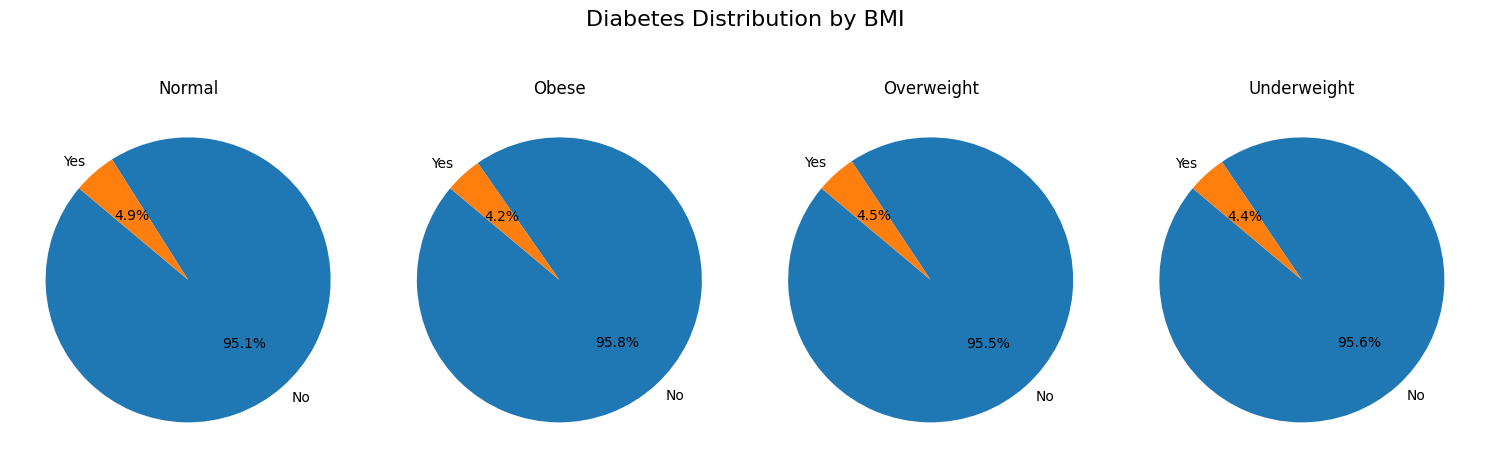

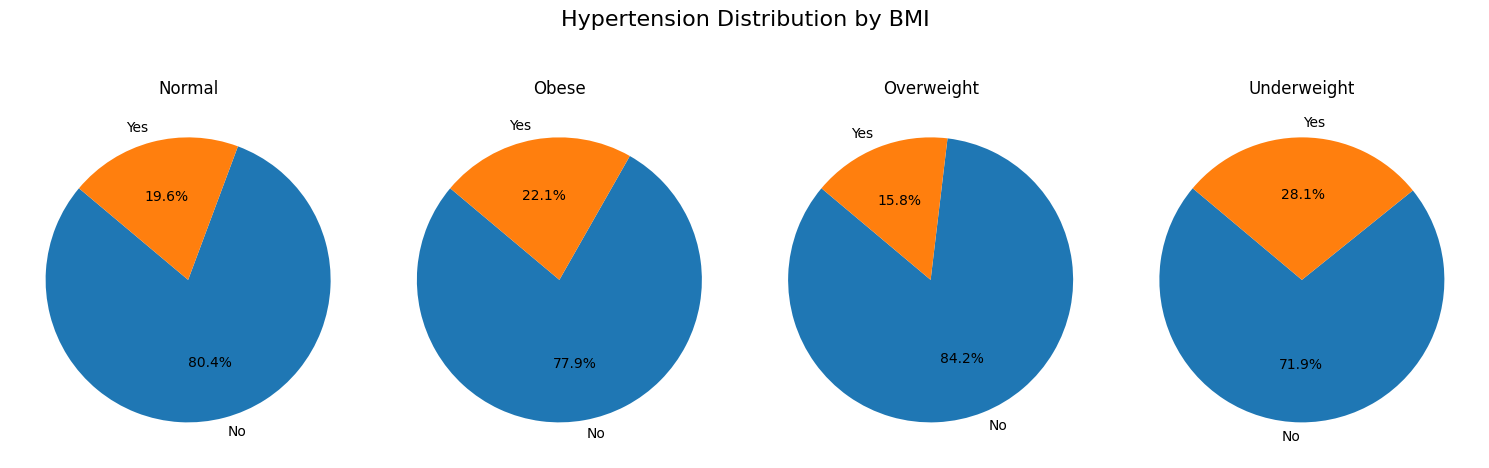

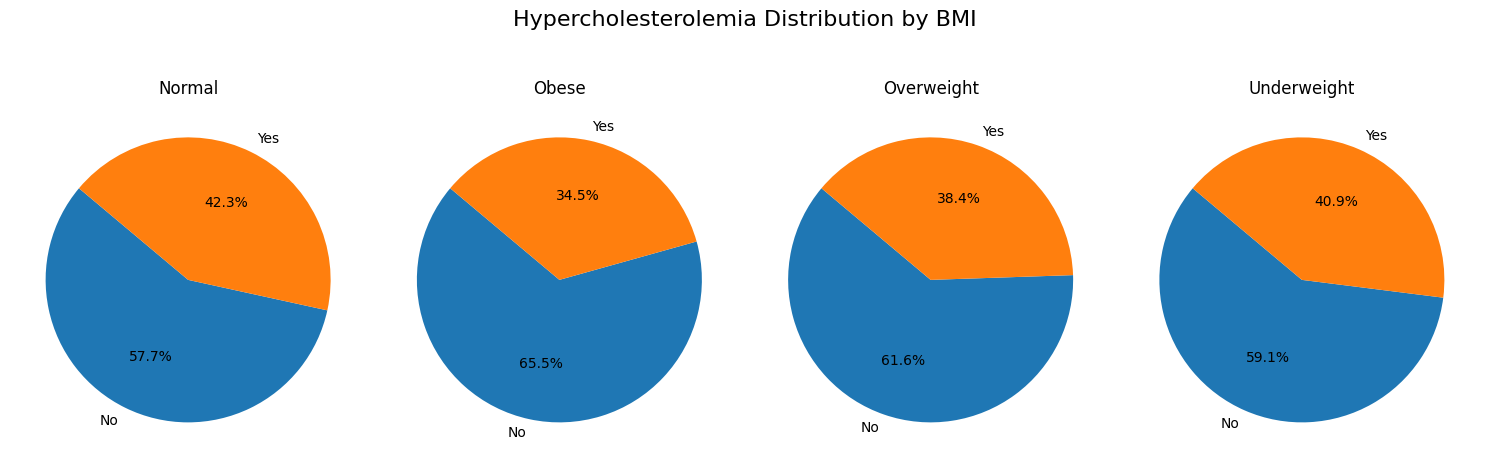

In [39]:
import matplotlib.pyplot as plt

# List of diseases to query
diseases = ['Diabetes', 'Hypertension', 'Hypercholesterolemia']

# Loop through each disease and create one image for each disease
for disease in diseases:
    # Create a figure for the current disease
    fig, axes = plt.subplots(1, len(train_data['BodyMassIndex'].unique()), figsize=(15, 5))
    
    # Loop through Body Mass Index values
    for i, bmi_value in enumerate(sorted(train_data['BodyMassIndex'].unique())):
        # Query the inference for the current disease and BMI value
        result = infer.query(variables=[disease], evidence={'BodyMassIndex': bmi_value})
        
        # Extract states and their probabilities
        states = result.state_names[disease]
        probabilities = result.values
        
        # Plot the pie chart for the current BMI value
        ax = axes[i]  # Access the subplot for the current BMI
        ax.pie(probabilities, labels=states, autopct='%1.1f%%', startangle=140)
        ax.set_title(f"{bmi_value}")
    
    # Adjust the layout and display the figure in the notebook
    fig.suptitle(f"{disease} Distribution by BMI", fontsize=16)
    fig.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust for the suptitle
    plt.show()  # Show the pie charts for the current disease



How socioeconomic status affects depression and sleep duration

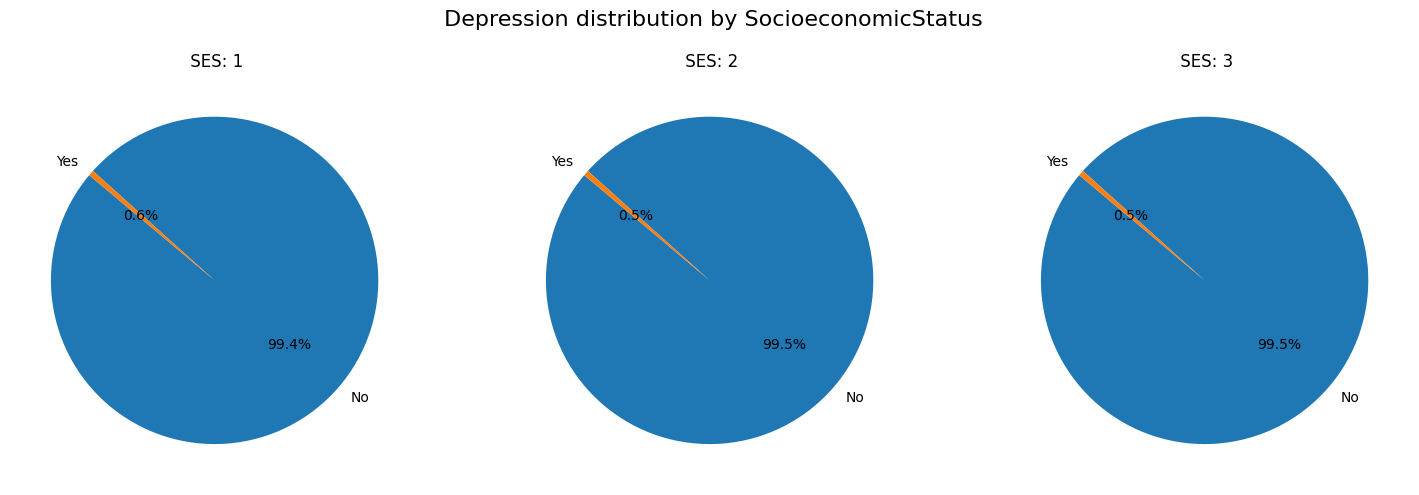

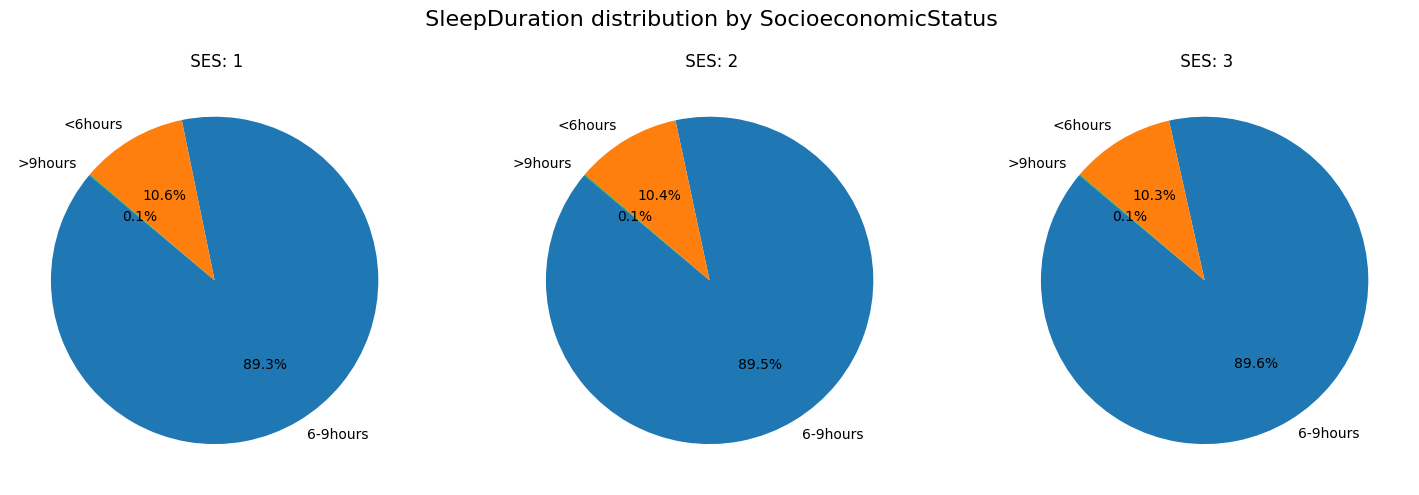

In [40]:
import matplotlib.pyplot as plt

# List of diseases to query
statuses = ['Depression', 'SleepDuration']

# Loop through each status to generate a separate graph for each
for status in statuses:
    # Create a figure for the current status
    fig, axes = plt.subplots(1, len(train_data['SocioeconomicStatus'].unique()), figsize=(15, 5))
    
    # Loop through SocioeconomicStatus values
    for j, ses_value in enumerate(sorted(train_data['SocioeconomicStatus'].unique())):
        # Query the inference for the status given SocioeconomicStatus
        result = infer.query(variables=[status], evidence={'SocioeconomicStatus': ses_value})
        
        # Extract states and their probabilities
        states = result.state_names[status]
        probabilities = result.values

        # Plot the pie chart for the current SocioeconomicStatus value
        ax = axes[j]  # Access the subplot for the current SocioeconomicStatus value
        ax.pie(probabilities, labels=states, autopct='%1.1f%%', startangle=140)
        ax.set_title(f" SES: {ses_value}")
    
    # Adjust the layout and display the figure in the notebook
    fig.suptitle(f" {status} distribution by SocioeconomicStatus", fontsize=16)
    fig.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust for the suptitle
    plt.show()  # Show the pie charts for the current status


How depression affects sleep duration ***NOT WHAT IS SHOWN***

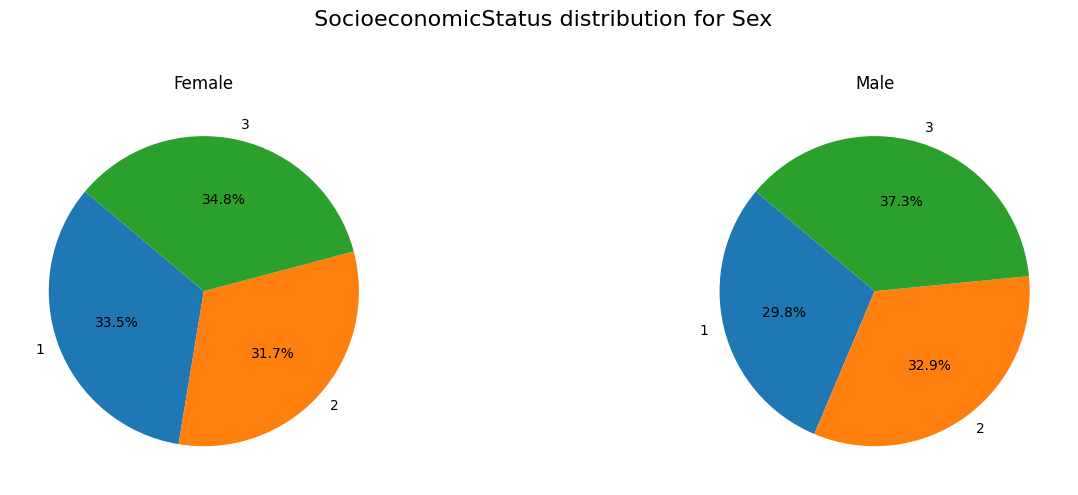

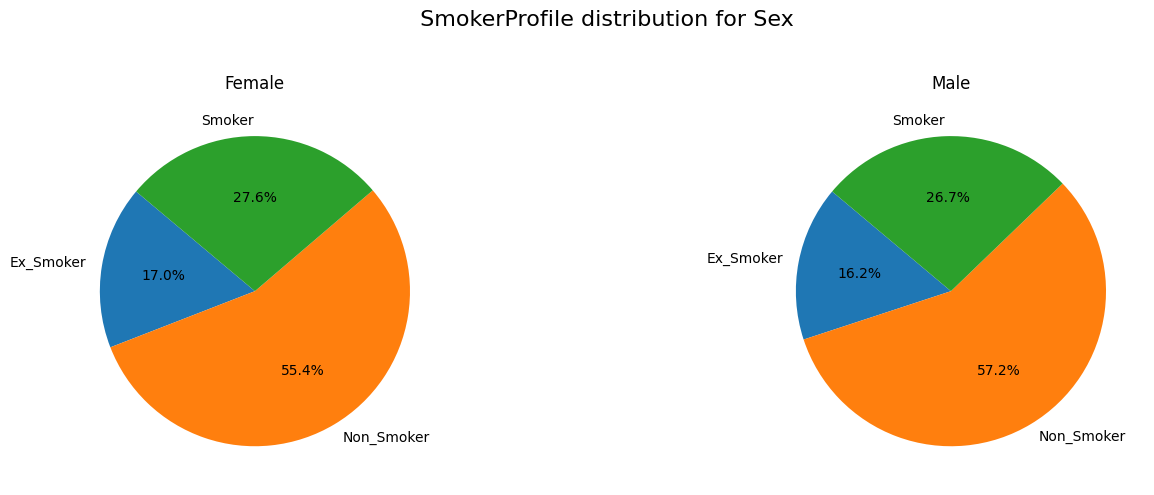

In [41]:
import matplotlib.pyplot as plt

# List of statuses (diseases or conditions) to query
statuses = ['SocioeconomicStatus', 'SmokerProfile']

# Loop through each status (disease) to generate a separate graph for each
for status in statuses:
    # Create a figure for the current status
    fig, axes = plt.subplots(1, len(sorted(train_data['Sex'].unique())), figsize=(15, 5))
    
    # Loop through SocioeconomicStatus values
    for j, sex in enumerate(sorted(train_data['Sex'].unique())):
        # Query the inference for the status (disease) given SocioeconomicStatus
        result = infer.query(variables=[status], evidence={'Sex': sex})
        
        # Extract states and their probabilities
        states = result.state_names[status]
        probabilities = result.values

        # Plot the pie chart for the current SocioeconomicStatus value
        ax = axes[j]  # Access the subplot for the current SocioeconomicStatus value
        ax.pie(probabilities, labels=states, autopct='%1.1f%%', startangle=140)
        ax.set_title(f"{sex}")
    
    # Add a main title for the current status
    fig.suptitle(f" {status} distribution for Sex", fontsize=16)
    
    # Adjust the layout and make space for the suptitle
    fig.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust for the suptitle
    plt.show()  # Show the pie charts for the current status


Classification of the three medical conditions.

In [42]:
def assess_classification(value, model, label):
    # Assuming test_data[value] contains string labels ('Yes' or 'No')
    true_values = test_data[value]
    predicted_values = model.predict(test_data.drop(columns=[value]))  # Assuming you have a trained model

    # Evaluate metrics using string labels
    accuracy = accuracy_score(true_values, predicted_values)
    precision = precision_score(true_values, predicted_values, pos_label=label)
    recall = recall_score(true_values, predicted_values,pos_label=label)
    f1 = f1_score(true_values, predicted_values,pos_label=label )

    # Print the evaluation metrics
    print(value)
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {f1}")

# Call this function for each disease
assess_classification("Diabetes",model,'Yes')
assess_classification("Hypertension",model,'Yes')
assess_classification("Hypercholesterolemia",model,'Yes')


100%|██████████| 808/808 [00:00<00:00, 1929.44it/s]
c:\Users\franc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Diabetes
Accuracy: 0.9547581903276131
Precision: 0.0
Recall: 0.0
F1-Score: 0.0


100%|██████████| 741/741 [00:00<00:00, 2528.30it/s]


Hypertension
Accuracy: 0.8369734789391575
Precision: 0.6438356164383562
Recall: 0.20434782608695654
F1-Score: 0.3102310231023102


100%|██████████| 704/704 [00:00<00:00, 2096.65it/s]


Hypercholesterolemia
Accuracy: 0.6872074882995319
Precision: 0.6360759493670886
Recall: 0.4127310061601643
F1-Score: 0.5006226650062267


Because diabetes is highly unbalanced the metrics come out as 0 because the model always predicts 1 so we need to apply smote to make the data more balanced , choose 0.3 because that way it slightly balances the data without creating too many values

C:\Users\franc\AppData\Local\Temp\ipykernel_11896\1855806307.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_data[binary_vars] = train_data[binary_vars].replace({'No': 0, 'Yes': 1})
C:\Users\franc\AppData\Local\Temp\ipykernel_11896\1855806307.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_data[binary_vars] = test_data[binary_vars].replace({'No': 0, 'Yes': 1})


3845
5136


  0%|          | 50/1000000 [00:01<8:17:11, 33.52it/s] 


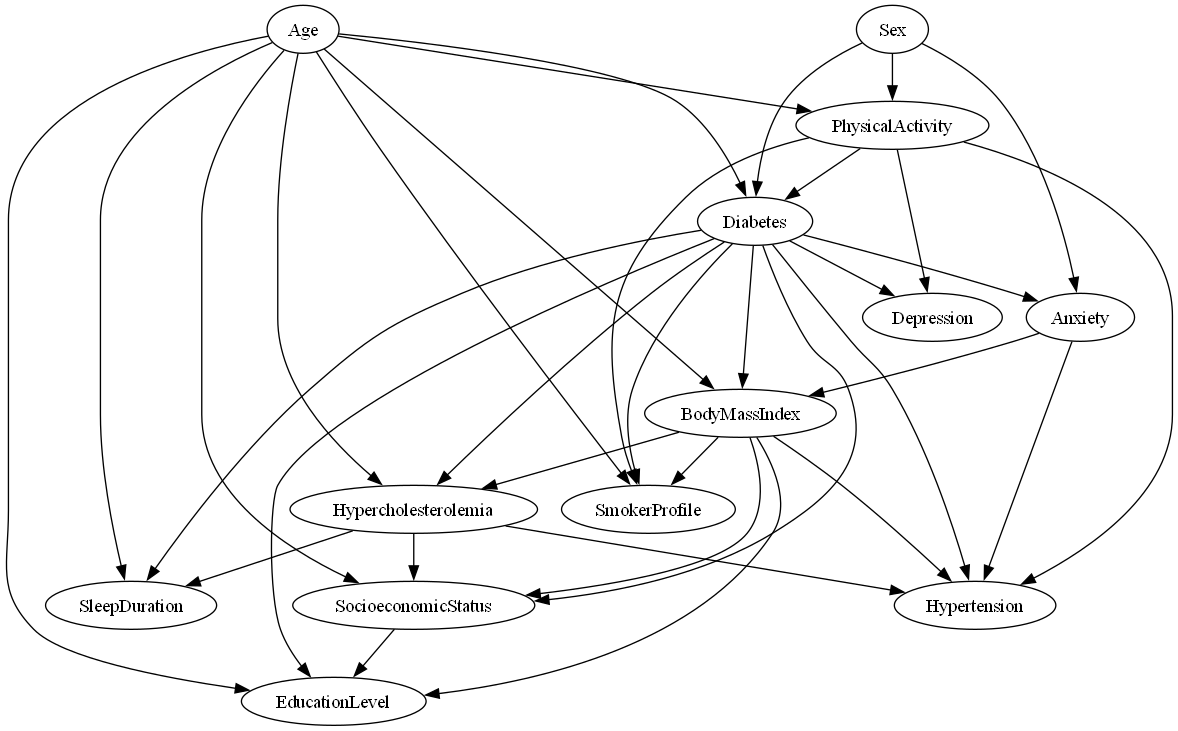

100%|██████████| 808/808 [00:00<00:00, 1739.08it/s]


Diabetes
Accuracy: 0.8673946957878315
Precision: 0.12666666666666668
Recall: 0.3275862068965517
F1-Score: 0.18269230769230768


In [46]:
train_data = pd.read_csv('cardiovascular_train.csv')
test_data = pd.read_csv('cardiovascular_test.csv')


binary_vars = ['Anxiety', 'Depression', 'Diabetes', 'Hypercholesterolemia', 'Hypertension']
train_data[binary_vars] = train_data[binary_vars].replace({'No': 0, 'Yes': 1})

test_data[binary_vars] = test_data[binary_vars].replace({'No': 0, 'Yes': 1})

train_data['Age'] = train_data['Age'].map({'18-24': 1, '24-34': 2, '34-44': 3, '44-54': 4, '54-64': 5, '64-74': 6})
train_data['BodyMassIndex'] = train_data['BodyMassIndex'].map({'Underweight': 1, 'Normal': 2, 'Overweight': 3, 'Obese': 4})
train_data['SleepDuration'] = train_data['SleepDuration'].map({'<6hours': 1, '6-9hours': 2, '>9hours': 3})

test_data['Age'] = test_data['Age'].map({'18-24': 1, '24-34': 2, '34-44': 3, '44-54': 4, '54-64': 5, '64-74': 6})
test_data['BodyMassIndex'] = test_data['BodyMassIndex'].map({'Underweight': 1, 'Normal': 2, 'Overweight': 3, 'Obese': 4})
test_data['SleepDuration'] = test_data['SleepDuration'].map({'<6hours': 1, '6-9hours': 2, '>9hours': 3})

# Assume train_data is your dataset
X = train_data.drop(columns=['Diabetes'])  # Features
y = train_data['Diabetes']  # Target variable
print(len(y))
# Apply SMOTE to the training data
smote = SMOTENC(random_state=42,categorical_features = ['PhysicalActivity','Sex','SmokerProfile'],sampling_strategy=0.4)
X_resampled, y_resampled = smote.fit_resample(X, y)
print(len(y_resampled))
# Combine X_resampled and y_resampled into a new DataFrame
resampled_data = pd.concat([X_resampled, y_resampled], axis=1)

best_model = best_by_scorer(AICScore(resampled_data))
graph = best_model.to_graphviz()
img = graph.draw(format='png', prog='dot')
display(Image(img))

model = BayesianNetwork(list(best_model.edges()))
model.fit(resampled_data,estimator=MaximumLikelihoodEstimator)

assess_classification("Diabetes",model, 1)

# Validate the model on the original dataset

